# Mounting the Google drive

In [2]:
from google.colab import drive
drive.mount('/content/drive/')

%cd /content/drive/MyDrive/CHD

Mounted at /content/drive/
/content/drive/MyDrive/CHD


# Introduction

The dataset was downloaded from this Kaggle [link](https://www.kaggle.com/competitions/congenital-heart-disease/data). The dataset has contains X-Ray images with 4 Classes ASD (Atrial Septal Defect), Normal X-Ray, VSD(Ventricular Septal Defect) and PDA (Patent Ductus Arteriosus), Each classes has around 200 Images. In this notebook we will preprocess the image and train Models so that we can any unknown image into these 4 classes.

In our next cell, we will unzip the downloaded dataset.

In [ ]:
!unzip /content/drive/MyDrive/CHD/Data/preprocessed_dataset.zip -d /content/drive/MyDrive/CHD/Data

# Preprocessing

Before we can proceed with training we need to first preprocess our images, in the next cell we will first import all the preprocessing library that we will need.

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
# !rm -rf /content/drive/MyDrive/CHD/preprocessed_dataset

After we have the dataset, first we need to split the dataset into training and validation set, so that during data augmentation, we can be sure that there are no data leakage. We are splitting the dataset into 80-20 ratio.

In [ ]:
input_dir = '/content/drive/MyDrive/CHD/Data/Data'
train_size=0.8
labels = []
filenames = []
for class_name in os.listdir(input_dir):
  class_dir = os.path.join(input_dir, class_name)


  for filename in tqdm(os.listdir(class_dir)):
    labels.append(class_name)
    filenames.append(filename)

train_labels, val_labels, train_filenames, val_filenames = train_test_split(labels, filenames, train_size=train_size)

100%|██████████| 210/210 [00:00<00:00, 1080740.91it/s]


## Preprocessing steps

*   We already have the train_labels, val_labels, train_filenames, val_filenames from our previous cell.
*   At first we will loop over the train_labels and train_filenames.
*   We will read the images with it's path using openCV as gray scale image.
*   We are extracting the height and width of images.
*   Then we will scale those images keeping the ratio of width and height as before, so that we dont lose any data.
*   We have equalized image histogram.
*   Used OpenCV Clahe for Contrast enhancing.
*   Used Median Blur to reduce the noises.
*   Rotated each image by 10 degrees.
*   Then normalised the images by dividing it by 255.
*   At the end, we are stacking those gray scale images to make it into 3 channels instead of 1, because the Neural Network we will train takes 3 Channels.
*   Finally, we will save the these preprocesses images as well as just resized and normalized images as numpy file.



In [ ]:
def preprocess_images(input_dir, output_train_dir):
    # Create output directories if they don't exist
    os.makedirs(output_train_dir, exist_ok=True)

    count = 0

    for train_label, train_filename in tqdm(zip(val_labels, val_filenames)):
        train_image_path = os.path.join(input_dir, train_label, train_filename)

        output_train_class_dir = os.path.join(output_train_dir, train_label)


        image = cv2.imread(train_image_path, cv2.IMREAD_GRAYSCALE)

        height, width = image.shape[:2]

        scaling_factor = 300 / min(height, width)

        image = cv2.resize(image, None, fx=scaling_factor, fy=scaling_factor)

        # equalized_image_with_blurred = cv2.equalizeHist(image)

        # # Apply CLAHE
        # clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        # clahe_image = clahe.apply(equalized_image_with_blurred)

        # blurred_image = cv2.medianBlur(clahe_image, 3)

        # rows, cols = blurred_image.shape
        # rotation_matrix = cv2.getRotationMatrix2D((cols / 2, rows / 2), 10, 1)
        # rotated_image = cv2.warpAffine(blurred_image, rotation_matrix, (cols, rows))


        # # # Normalize pixel values
        image = image.astype(np.float32) / 255.0
        # normalized_image_clahe_blurred = blurred_image.astype(np.float32) / 255.0


        rgb_image = cv2.merge([image, image, image])
        # rgb_image_clahe = cv2.merge([normalized_image_clahe_blurred, normalized_image_clahe_blurred, normalized_image_clahe_blurred])

        train_filename = train_filename.split(".")[0]

        # train_file_name_aug = train_filename + "_augmented"

        os.makedirs(output_train_class_dir, exist_ok=True)
        # os.makedirs(output_val_class_dir, exist_ok=True)

        output_train_path = os.path.join(output_train_class_dir, train_filename)
        # output_train_path_aug = os.path.join(output_train_class_dir, train_file_name_aug)

        np.save(output_train_path, rgb_image)
        # np.save(output_train_path_aug, rgb_image_clahe)

Here we are calling the above function, so that we can create and preprocess train and validation data.

In [ ]:
# Example usage
input_dir = 'Data/Data'
output_train_dir = 'preprocessed_dataset/val'
preprocess_images(input_dir, output_train_dir)

0it [00:00, ?it/s]

In [ ]:
len(os.listdir("/content/drive/MyDrive/CHD/preprocessed_dataset/train/Normal"))

334

Plotting our preprocessed image

(360, 300, 3)


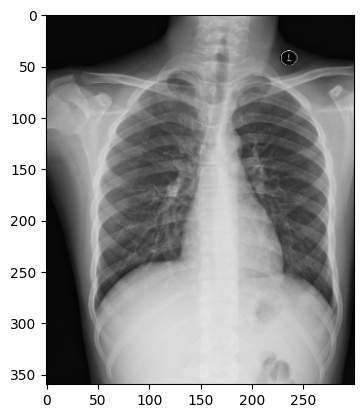

In [ ]:
from matplotlib import pyplot as plt

image = np.load("/content/drive/MyDrive/CHD/preprocessed_dataset/val/ASD/ASD01.npy")

print(image.shape)

plt.imshow(image, cmap = 'bone')

# Dataset Preparation
In this cell we are importing all the neccessary libraries for training the model.

In [3]:
import os
from PIL import Image
from matplotlib import pyplot as plt
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
from tqdm.notebook import tqdm
torch.manual_seed(42)

## Creating the dataloader

here we have train and validation transform, where


*   We are converting train dataset into tensor, rotating it by 10 degrees, and scaling it. Then cropping it by centre.
*   In validation transform, we are converting it into tensor and cropping it by centre.

The cropping part also works as Region of interest because, the heart is mostly at the middle of the chest X-Ray.



In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1)),  # Random affine transformation
    transforms.CenterCrop((299, 299)),  # Random resized crop# Convert the image to a PyTorch tensor
])


val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.CenterCrop((299, 299)),
])

Creating a load_file function which will be used to load the files as loader argument of torch DatasetFolder method.

In [5]:
import numpy as np

def load_file(path):
  return np.load(path).astype(np.float32)

Over here We are creating, train_dataset and val_dataset using Pytorch DatasetFolder, where each class gets converted into categorical form as following - ASD = 0, Normal = 1, PDA = 2, VSD = 3.

We can see in the output cell that, our train dataset has 662 classes and val dataset has 166 classes.

In [ ]:

# datasets.DatasetFolder.make_dataset(directory="Data", class_to_idx={'ASD': 1, 'Normal': 0, 'PDA': 2, 'VSD': 3})

# Instantiate the DatasetFolder with proper class labels
train_dataset = datasets.DatasetFolder(
    root="preprocessed_dataset/train",
    loader=load_file,
    extensions='.npy',
    transform=train_transform,
)
val_dataset = datasets.DatasetFolder(
    root="preprocessed_dataset/val",
    loader=load_file,
    extensions='.npy',
    transform=train_transform,
)

# Number of classes for multi-class classification
num_classes = len(train_dataset.classes)

print("Number of classes:", num_classes)
print("train dataset: ", len(train_dataset))
print("val dataset: ", len(val_dataset))

Number of classes: 4
train dataset:  662
val dataset:  166


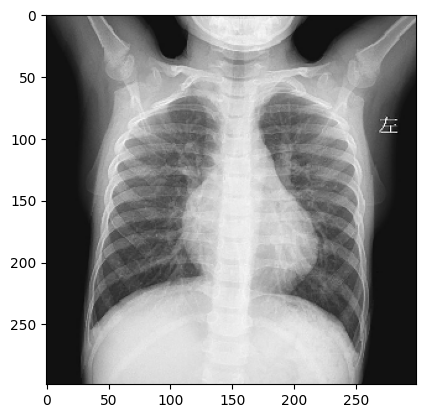

In [ ]:
plt.imshow(train_dataset[3][0].squeeze(dim = 0).permute(1, 2, 0), cmap = "bone")

At the end we will create our train_loader and val_loader to feed it into the Neural Net.

In [ ]:
batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Modelling

Over here we are defining a CHDModelResnet class, which will be our ResNet50 model with it's pretrained weights.

In [3]:
class CHDModelResnet(torch.nn.Module):
    def __init__(self, num_classes):
        super(CHDModelResnet, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)

    def forward(self, x):
        return self.model(x)


Installing efficientnet_pytorch library

In [6]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

Over here we are defining a CHDModelEfficientNet class, which will be our Efficientnet-B4 model with it's pretrained weights.



In [62]:
from efficientnet_pytorch import EfficientNet

class CHDModelEfficientNet(torch.nn.Module):
    def __init__(self, num_classes=4):
        super(CHDModelEfficientNet, self).__init__()
        self.base_model = EfficientNet.from_pretrained('efficientnet-b4')

        num_ftrs = self.base_model._fc.in_features
        self.base_model._fc = torch.nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.base_model(x)

Over here we are defining a CHDModelInceptionNet class, which will be our Inception V3 model with it's pretrained weights.


In [63]:
class CHDModelInceptionNet(torch.nn.Module):
    def __init__(self, num_classes):
        super(CHDModelInceptionNet, self).__init__()
        self.model = torchvision.models.inception_v3(pretrained=True)

        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(num_ftrs, num_classes)

    def forward(self, x):
        return self.model(x)

# Training

Here we are intializing few things.


*   device
*   num_classes - number of classes that will be our Model's output.
*   model - Initializing the model.
*   epoch - We will train our models for 60 epochs

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4  # assuming 4 classes: ASD, Normal, PDA, VSD
model = CHDModelInceptionNet(num_classes).to(device)
epoch = 60

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
input = torch.randn(2, 3, 299, 299).to(device)
model(input)

InceptionOutputs(logits=tensor([[-0.2256,  0.4263, -0.0474, -0.3016],
        [-0.6970,  0.0639,  0.0568,  0.0511]], device='cuda:0',
       grad_fn=<AddmmBackward0>), aux_logits=tensor([[-0.6799, -1.6828,  1.2916,  ...,  1.3867,  0.3347,  1.7077],
        [ 0.5173,  1.3083, -1.8195,  ..., -1.8600, -0.5272, -1.8355]],
       device='cuda:0', grad_fn=<AddmmBackward0>))

Here are few more things, before we start training.



*   We are using Cross Entropy Loss because it is a multiclass cassification problem.
*   We are also using ADAM optimizer with learing rate 1e-4.
*   At the end, we are defining a scheduler which will reduce our learning rate by 70% after every 6 epochs.



In [ ]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.7)

Now for the traing part,


*   We will send our data with 16 batch size.
*   At the end, we will save the best model by our validation accuracy.



In [ ]:
best_val_accuracy = 0.0  # Variable to store the best validation accuracy
best_model_state_dict = None  # Variable to store the state dict of the best model
best_epoch = 0  # Variable to store the epoch number of the best model

for epoch in range(60):  # Loop over the dataset multiple times
    model.train()  # Set the model to training mode
    running_loss = 0.0
    running_accuracy = 0.0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(inputs)

        outputs = outputs.logits

        # Use CrossEntropyLoss for multi-class classification
        loss = criterion(outputs, labels)

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct = (predicted == labels).sum().item()
        accuracy = correct / labels.size(0)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_accuracy += accuracy

    train_loss = running_loss / len(train_loader)
    train_accuracy = running_accuracy / len(train_loader)
    scheduler.step()

    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_running_loss = 0.0
    val_running_accuracy = 0.0
    with torch.no_grad():  # Inference mode, no need to calculate gradients
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            # Use CrossEntropyLoss for multi-class classification
            loss = criterion(outputs, labels)

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct = (predicted == labels).sum().item()
            accuracy = correct / labels.size(0)

            val_running_loss += loss.item()
            val_running_accuracy += accuracy

    val_loss = val_running_loss / len(val_loader)
    val_accuracy = val_running_accuracy / len(val_loader)

    print(f'Epoch {epoch + 1}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_state_dict = model.state_dict()
        best_epoch = epoch + 1

print('Finished Training')

# Save the best model
torch.save(best_model_state_dict, f'inceptionv3_pretrained_new8_{best_epoch}.pth')


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 1, Train Loss: 1.1961, Train Acc: 0.4469, Val Loss: 0.9988, Val Acc: 0.6098


100%|██████████| 42/42 [00:13<00:00,  3.04it/s]


Epoch 2, Train Loss: 0.7831, Train Acc: 0.6860, Val Loss: 0.7176, Val Acc: 0.6932


100%|██████████| 42/42 [00:13<00:00,  3.05it/s]


Epoch 3, Train Loss: 0.5856, Train Acc: 0.7812, Val Loss: 0.5957, Val Acc: 0.7614


100%|██████████| 42/42 [00:13<00:00,  3.03it/s]


Epoch 4, Train Loss: 0.3897, Train Acc: 0.8562, Val Loss: 0.6219, Val Acc: 0.7595


100%|██████████| 42/42 [00:13<00:00,  3.03it/s]


Epoch 5, Train Loss: 0.3851, Train Acc: 0.8502, Val Loss: 0.6528, Val Acc: 0.7519


100%|██████████| 42/42 [00:13<00:00,  3.02it/s]


Epoch 6, Train Loss: 0.2954, Train Acc: 0.9043, Val Loss: 0.6722, Val Acc: 0.7462


100%|██████████| 42/42 [00:13<00:00,  3.01it/s]


Epoch 7, Train Loss: 0.1971, Train Acc: 0.9390, Val Loss: 0.5147, Val Acc: 0.8390


100%|██████████| 42/42 [00:13<00:00,  3.00it/s]


Epoch 8, Train Loss: 0.1614, Train Acc: 0.9499, Val Loss: 0.5380, Val Acc: 0.7822


100%|██████████| 42/42 [00:13<00:00,  3.03it/s]


Epoch 9, Train Loss: 0.1758, Train Acc: 0.9439, Val Loss: 0.6663, Val Acc: 0.7633


100%|██████████| 42/42 [00:13<00:00,  3.01it/s]


Epoch 10, Train Loss: 0.2045, Train Acc: 0.9311, Val Loss: 0.7782, Val Acc: 0.7557


100%|██████████| 42/42 [00:13<00:00,  3.02it/s]


Epoch 11, Train Loss: 0.1239, Train Acc: 0.9633, Val Loss: 0.6059, Val Acc: 0.7822


100%|██████████| 42/42 [00:13<00:00,  3.02it/s]


Epoch 12, Train Loss: 0.1330, Train Acc: 0.9588, Val Loss: 0.6247, Val Acc: 0.7538


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 13, Train Loss: 0.1040, Train Acc: 0.9702, Val Loss: 0.5346, Val Acc: 0.8201


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 14, Train Loss: 0.1031, Train Acc: 0.9692, Val Loss: 0.4446, Val Acc: 0.8277


100%|██████████| 42/42 [00:13<00:00,  3.02it/s]


Epoch 15, Train Loss: 0.0671, Train Acc: 0.9821, Val Loss: 0.6272, Val Acc: 0.8049


100%|██████████| 42/42 [00:14<00:00,  2.99it/s]


Epoch 16, Train Loss: 0.0428, Train Acc: 0.9926, Val Loss: 0.5667, Val Acc: 0.7955


100%|██████████| 42/42 [00:13<00:00,  3.01it/s]


Epoch 17, Train Loss: 0.0513, Train Acc: 0.9886, Val Loss: 0.4783, Val Acc: 0.8011


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Epoch 18, Train Loss: 0.0930, Train Acc: 0.9717, Val Loss: 0.7387, Val Acc: 0.7424


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 19, Train Loss: 0.0483, Train Acc: 0.9866, Val Loss: 0.4896, Val Acc: 0.8542


100%|██████████| 42/42 [00:14<00:00,  2.94it/s]


Epoch 20, Train Loss: 0.0419, Train Acc: 0.9866, Val Loss: 0.4691, Val Acc: 0.8295


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 21, Train Loss: 0.0350, Train Acc: 0.9911, Val Loss: 0.5008, Val Acc: 0.8220


100%|██████████| 42/42 [00:14<00:00,  3.00it/s]


Epoch 22, Train Loss: 0.0356, Train Acc: 0.9911, Val Loss: 0.5850, Val Acc: 0.8163


100%|██████████| 42/42 [00:14<00:00,  2.99it/s]


Epoch 23, Train Loss: 0.0308, Train Acc: 0.9926, Val Loss: 0.5353, Val Acc: 0.8333


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Epoch 24, Train Loss: 0.0567, Train Acc: 0.9856, Val Loss: 0.5768, Val Acc: 0.8068


100%|██████████| 42/42 [00:13<00:00,  3.00it/s]


Epoch 25, Train Loss: 0.0386, Train Acc: 0.9926, Val Loss: 0.5295, Val Acc: 0.8030


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 26, Train Loss: 0.0326, Train Acc: 0.9916, Val Loss: 0.6354, Val Acc: 0.7992


100%|██████████| 42/42 [00:14<00:00,  2.94it/s]


Epoch 27, Train Loss: 0.0486, Train Acc: 0.9881, Val Loss: 0.5206, Val Acc: 0.8125


100%|██████████| 42/42 [00:14<00:00,  2.99it/s]


Epoch 28, Train Loss: 0.0334, Train Acc: 0.9911, Val Loss: 0.5562, Val Acc: 0.8125


100%|██████████| 42/42 [00:14<00:00,  2.99it/s]


Epoch 29, Train Loss: 0.0243, Train Acc: 0.9970, Val Loss: 0.4851, Val Acc: 0.8561


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Epoch 30, Train Loss: 0.0190, Train Acc: 0.9985, Val Loss: 0.4848, Val Acc: 0.8485


100%|██████████| 42/42 [00:14<00:00,  2.96it/s]


Epoch 31, Train Loss: 0.0290, Train Acc: 0.9926, Val Loss: 0.5031, Val Acc: 0.8182


100%|██████████| 42/42 [00:14<00:00,  3.00it/s]


Epoch 32, Train Loss: 0.0180, Train Acc: 0.9955, Val Loss: 0.5250, Val Acc: 0.8106


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Epoch 33, Train Loss: 0.0133, Train Acc: 0.9985, Val Loss: 0.6279, Val Acc: 0.7708


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 34, Train Loss: 0.0162, Train Acc: 0.9926, Val Loss: 0.4677, Val Acc: 0.8712


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Epoch 35, Train Loss: 0.0271, Train Acc: 0.9926, Val Loss: 0.6212, Val Acc: 0.7992


100%|██████████| 42/42 [00:13<00:00,  3.00it/s]


Epoch 36, Train Loss: 0.0544, Train Acc: 0.9861, Val Loss: 0.4993, Val Acc: 0.8049


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 37, Train Loss: 0.0288, Train Acc: 0.9940, Val Loss: 0.5288, Val Acc: 0.8125


100%|██████████| 42/42 [00:14<00:00,  2.99it/s]


Epoch 38, Train Loss: 0.0242, Train Acc: 0.9906, Val Loss: 0.5489, Val Acc: 0.8220


100%|██████████| 42/42 [00:14<00:00,  2.99it/s]


Epoch 39, Train Loss: 0.0117, Train Acc: 0.9985, Val Loss: 0.6147, Val Acc: 0.8220


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 40, Train Loss: 0.0269, Train Acc: 0.9931, Val Loss: 0.5226, Val Acc: 0.8390


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Epoch 41, Train Loss: 0.0203, Train Acc: 0.9955, Val Loss: 0.5162, Val Acc: 0.8466


100%|██████████| 42/42 [00:14<00:00,  3.00it/s]


Epoch 42, Train Loss: 0.0451, Train Acc: 0.9876, Val Loss: 0.6014, Val Acc: 0.7917


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 43, Train Loss: 0.0254, Train Acc: 0.9945, Val Loss: 0.4885, Val Acc: 0.8447


100%|██████████| 42/42 [00:14<00:00,  3.00it/s]


Epoch 44, Train Loss: 0.0339, Train Acc: 0.9886, Val Loss: 0.5213, Val Acc: 0.8295


100%|██████████| 42/42 [00:14<00:00,  2.96it/s]


Epoch 45, Train Loss: 0.0130, Train Acc: 0.9985, Val Loss: 0.4757, Val Acc: 0.8182


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Epoch 46, Train Loss: 0.0144, Train Acc: 0.9985, Val Loss: 0.4848, Val Acc: 0.8542


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Epoch 47, Train Loss: 0.0178, Train Acc: 0.9985, Val Loss: 0.5884, Val Acc: 0.8030


100%|██████████| 42/42 [00:14<00:00,  2.97it/s]


Epoch 48, Train Loss: 0.0127, Train Acc: 0.9985, Val Loss: 0.5551, Val Acc: 0.8220


100%|██████████| 42/42 [00:14<00:00,  2.99it/s]


Epoch 49, Train Loss: 0.0138, Train Acc: 1.0000, Val Loss: 0.5368, Val Acc: 0.8447


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 50, Train Loss: 0.0159, Train Acc: 0.9970, Val Loss: 0.5105, Val Acc: 0.8277


100%|██████████| 42/42 [00:14<00:00,  2.98it/s]


Epoch 51, Train Loss: 0.0204, Train Acc: 0.9970, Val Loss: 0.4907, Val Acc: 0.8220


100%|██████████| 42/42 [00:14<00:00,  2.99it/s]


Epoch 52, Train Loss: 0.0130, Train Acc: 0.9960, Val Loss: 0.5047, Val Acc: 0.8447


100%|██████████| 42/42 [00:14<00:00,  2.96it/s]


Epoch 53, Train Loss: 0.0095, Train Acc: 1.0000, Val Loss: 0.5346, Val Acc: 0.8087


100%|██████████| 42/42 [00:14<00:00,  2.93it/s]


Epoch 54, Train Loss: 0.0084, Train Acc: 0.9985, Val Loss: 0.5570, Val Acc: 0.8447


100%|██████████| 42/42 [00:14<00:00,  2.95it/s]


Epoch 55, Train Loss: 0.0097, Train Acc: 1.0000, Val Loss: 0.5142, Val Acc: 0.8390


100%|██████████| 42/42 [00:14<00:00,  2.91it/s]


Epoch 56, Train Loss: 0.0193, Train Acc: 0.9940, Val Loss: 0.5185, Val Acc: 0.8163


100%|██████████| 42/42 [00:14<00:00,  2.96it/s]


Epoch 57, Train Loss: 0.0250, Train Acc: 0.9955, Val Loss: 0.5463, Val Acc: 0.8239


100%|██████████| 42/42 [00:14<00:00,  2.96it/s]


Epoch 58, Train Loss: 0.0073, Train Acc: 1.0000, Val Loss: 0.5340, Val Acc: 0.8144


100%|██████████| 42/42 [00:14<00:00,  2.96it/s]


Epoch 59, Train Loss: 0.0173, Train Acc: 0.9985, Val Loss: 0.5402, Val Acc: 0.8068


100%|██████████| 42/42 [00:14<00:00,  2.96it/s]


Epoch 60, Train Loss: 0.0215, Train Acc: 0.9955, Val Loss: 0.5265, Val Acc: 0.8428
Finished Training


# Evaluation

We will first load our models that we have trained in the next three cells

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = 4

Added feature map for Visualization

In [123]:
class CHDModelResnet(torch.nn.Module):
    def __init__(self, num_classes):
        super(CHDModelResnet, self).__init__()
        self.model = torchvision.models.resnet50(pretrained=True)
        num_ftrs = self.model.fc.in_features
        self.model.fc = torch.nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)

        self.feature_map = {}

    def forward(self, x):
        self.feature_map['layer4'] = torch.nn.Sequential(*list(self.model.children())[:-2])(x)
        pred = self.model(x)

        return pred


In [124]:
resnet_weights_path = "/content/drive/MyDrive/CHD/best_model_resnet50_pretrained_new8_42.pth"
resnet_model = CHDModelResnet(num_classes).to(device)
resnet_model.load_state_dict(torch.load(resnet_weights_path))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [65]:
effnet_weights_path = "/content/drive/MyDrive/CHD/best_model_effnetb6_pretrained_new8_33.pth"
effnet_model = CHDModelEfficientNet(num_classes).to(device)
effnet_model.load_state_dict(torch.load(effnet_weights_path))

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth
100%|██████████| 74.4M/74.4M [00:00<00:00, 426MB/s]


Loaded pretrained weights for efficientnet-b4


<All keys matched successfully>

In [66]:
inception_weights_path = "/content/drive/MyDrive/CHD/inceptionv3_pretrained_new8_34.pth"
inception_model = CHDModelInceptionNet(num_classes).to(device)
inception_model.load_state_dict(torch.load(inception_weights_path))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 71.6MB/s] 


<All keys matched successfully>

Here, transform will transform, scale, rotate and crop our images, but here we are creating 3 transforms for 3 different models.

In [67]:
inception_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1)),
    transforms.CenterCrop((299, 299)),
])

effnet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1)),
    transforms.CenterCrop((224, 224)),
])

resnet_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=10, scale=(0.9, 1.1)),
    transforms.CenterCrop((224, 224)),
])

In [68]:
inception_dataset = datasets.DatasetFolder(
    root="preprocessed_dataset/val",
    loader=load_file,
    extensions='.npy',
    transform=inception_transform,
)

effnet_dataset = datasets.DatasetFolder(
    root="preprocessed_dataset/val",
    loader=load_file,
    extensions='.npy',
    transform=effnet_transform,
)

resnet_dataset = datasets.DatasetFolder(
    root="preprocessed_dataset/val",
    loader=load_file,
    extensions='.npy',
    transform=resnet_transform,
)

In [69]:
inception_loader = DataLoader(inception_dataset, batch_size=1, shuffle=False)
effnet_loader = DataLoader(effnet_dataset, batch_size=1, shuffle=False)
resnet_loader = DataLoader(resnet_dataset, batch_size=1, shuffle=False)

Here, we have created calculater_accuracy function which will take the model as well as the dataloader to calculate and the print the accuracy

In [70]:
def calculater_accuracy(data_loader, model):
  val_accuracy = 0.0
  val_running_corrects = 0
  val_total_samples = 0

  # Set the model to evaluation mode
  model.eval()

  with torch.no_grad():  # Inference mode, no need to calculate gradients
      for inputs, labels in tqdm(data_loader):
          inputs, labels = inputs.to(device), labels.to(device)

          # Forward pass
          outputs = model(inputs)

          # Get predicted labels
          _, preds = torch.max(outputs, 1)

          # Update total number of samples
          val_total_samples += labels.size(0)

          # Update number of correct predictions
          val_running_corrects += torch.sum(preds == labels.data)

  # Calculate accuracy
  val_accuracy = val_running_corrects.double() / val_total_samples

  print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))


Accuracy of Inception Model

In [71]:
# torch.manual_seed(42)
calculater_accuracy(inception_loader, inception_model)

  0%|          | 0/166 [00:00<?, ?it/s]

Validation Accuracy: 84.94%


Accuracy of Efficient Net Model

In [72]:
# torch.manual_seed(42)
calculater_accuracy(effnet_loader, effnet_model)

  0%|          | 0/166 [00:00<?, ?it/s]

Validation Accuracy: 86.14%


Accuracy of ResNet Model

In [73]:
# torch.manual_seed(42)
calculater_accuracy(resnet_loader, resnet_model)

  0%|          | 0/166 [00:00<?, ?it/s]

Validation Accuracy: 88.55%


At the end, we using all three models to classify an image using voting classifier, and calculating the accuracy.

In [53]:
# prompt: At the end, we using all three models to classify an image using voting classifier, and calculating the accuracy.

def voting_classifier(model1, model2, model3, data_loader):
  val_running_corrects = 0
  val_total_samples = 0

  # Set the models to evaluation mode
  model1.eval()
  model2.eval()
  model3.eval()

  with torch.no_grad():  # Inference mode, no need to calculate gradients
      for inputs, labels in tqdm(data_loader):
          inputs, labels = inputs.to(device), labels.to(device)

          # Forward pass for each model

          resnet_outputs = resnet_model(inputs)
          effnet_outputs = effnet_model(inputs)
          inception_outputs = inception_model(inputs)

          # Calculate combined outputs using adjusted weights
          combined_outputs = (resnet_outputs + effnet_outputs  + inception_outputs) / 3

          # Get predicted labels
          _, preds = torch.max(combined_outputs, 1)

          # Update total number of samples
          val_total_samples += labels.size(0)

          # Update number of correct predictions
          val_running_corrects += torch.sum(preds == labels.data)

  # Calculate accuracy
  val_accuracy = val_running_corrects.double() / val_total_samples

  print("Validation Accuracy (Voting Classifier): {:.2f}%".format(val_accuracy * 100))

# Accuracy of Voting Classifier
# torch.manual_seed(42)
voting_classifier(inception_model, effnet_model, resnet_model, inception_loader)


  0%|          | 0/166 [00:00<?, ?it/s]

Validation Accuracy (Voting Classifier): 86.75%


# Visualization

Here, we have visualized
* What our NeuralNet is learning by generating heatmaps.
* Where it is focusing to classify the images.
* For this we have taken the weights from last Conv layer.

We have only done it for Resnet50, but it can be be done for different classes and different model.

In [139]:
with torch.no_grad():  # Inference mode, no need to calculate gradients
    resnet_model.eval()
    pred = resnet_model(resnet_dataset[0][0].unsqueeze(0).cuda())
    feature_map = resnet_model.feature_map['layer4']

feature = feature_map.reshape((2048, 49))

weight_params = list(resnet_model.model.fc.parameters())[0]
weight = weight_params[0].detach()

print(feature.shape, weight.shape)
cam = torch.matmul(weight, feature)
  # cam_img = cam.reshape(7, 7).cpu()

    # return cam_img, torch.sigmoid(pred)
# Print the shapes of the feature maps
print("Shape of feature map 1:", feature_map.shape)
# print("Shape of feature map 2:", feature_map2.shape)

torch.Size([2048, 49]) torch.Size([2048])
Shape of feature map 1: torch.Size([1, 2048, 7, 7])


In [181]:
def cam(model, img):
    with torch.no_grad():  # Inference mode, no need to calculate gradients
      resnet_model.eval()
      pred = resnet_model(resnet_dataset[0][0].unsqueeze(0).cuda())
      feature_map = resnet_model.feature_map['layer4']

    feature = feature_map.reshape((2048, 49))

    weight_params = list(model.model.fc.parameters())[0]
    weight = weight_params[0].detach()

    cam = torch.matmul(weight, feature)
    cam_img = cam.reshape(7, 7).cpu()

    return cam_img, pred

In [187]:
def visualize(img, cam, pred):
    cam = transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    fig, axis = plt.subplots(1, 2)
    axis[0].imshow(img, cmap="bone")
    axis[1].imshow(img, cmap="bone")
    axis[1].imshow(cam, alpha = 0.5, cmap="jet")
    # plt.title(pred)

In [188]:
img = resnet_dataset[-6][0].unsqueeze(0).cuda()  # Select a subject
activation_map, pred = cam(resnet_model, img)

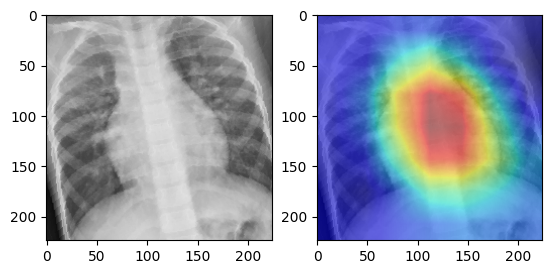

In [189]:
visualize(img.squeeze(dim = 0).permute(1, 2, 0).cpu(), activation_map, pred.cpu())